In [1]:
import csv

from matplotlib import pyplot as plt
import numpy as np

In [2]:
def get_data(name, column='Last'):
    """
    Data for this function should be taken from https://www.nasdaq.com/market-activity/stocks/*/historical,
    where '*' is the name of company.
    """
    number = {'Last': 1, 'Open': 3, 'High': 4, 'Low': 5}[column]
    with open(name+'.csv', 'r') as csvfile:
        data_reader = csv.reader(csvfile, delimiter=',', quotechar='|')
        res = np.array([float(e[2:]) for e in [row[number] for row in data_reader][:0:-1]])
    return res

In [3]:
def plot(data, name=''):
    plt.plot(data)
    plt.title(name)
    plt.xlabel('days')
    plt.ylabel('price, $')
    plt.grid()
    plt.show()

In [4]:
def SSA_get_optimal_r(x, return_V=False, eps=0.1):
    """
    Uses binsearch to find optimal r to use in SSA predict.
    """
    tau = (len(x) + 1) // 2
    n = len(x) + 1 - tau
    X = np.array([x[i: i + n] for i in range(tau)])
    w, V = np.linalg.eig(X @ X.T / n)
    Y = V.T @ X
    
    bot, top = 0, tau
    while True:
        m = (bot + top) // 2
        X_tilda = V[:, : m] @ Y[: m]
        x_tilda = np.array([np.mean(X_tilda[:, ::-1].diagonal(n - i - 1)) for i in range(len(x))])
        diff = np.max(np.abs(x - x_tilda))
        if diff >= eps:
            bot = m
        else:
            top = m
        if top - bot == 1:
            if return_V:
                return top, V
            else:
                return top

In [5]:
def SSA_predict(x, r=None, size=None):
    tau = (len(x) + 1) // 2
    if r is None:
        r, V = SSA_get_optimal_r(x, True)
    else:
        n = len(x) + 1 - tau
        X = np.array([x[i: i + n] for i in range(tau)])
        _, V = np.linalg.eig(X @ X.T / n)
    v_tau = V[-1, : r]
    v_tau_V_spark_T = v_tau @ V[: tau - 1, : r].T
    denom = 1 - v_tau @ v_tau.T
    if size is None:
        Q = x[-tau + 1:]
        return (v_tau_V_spark_T @ Q) / denom
    else:
        res = np.empty(size)
        for i in range(size):
            Q = np.hstack([x[-tau + 1 + i:], res[: i]])
            res[i] = (v_tau_V_spark_T @ Q) / denom
        return res

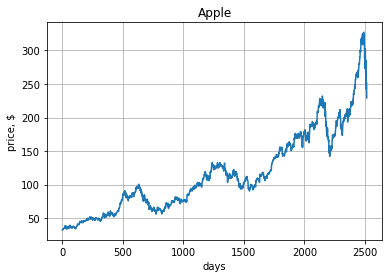

In [6]:
name = 'Apple'
data = get_data(name)
plot(data, name)

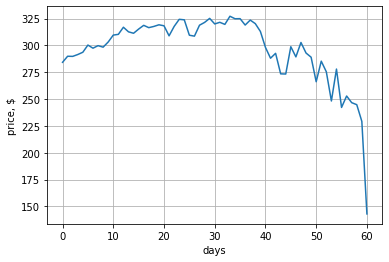

In [7]:
data_pred = SSA_predict(data)
plot(np.hstack([data[-60:], data_pred]))